In [6]:
import torch
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch.nn import Dropout, Linear
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, BatchNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from einops import rearrange
import numpy as np
import os
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

from hik.data.scene import Scene
from hik.vis.pose import get_meta

ModuleNotFoundError: No module named 'hik.data'

In [4]:
# Example: define data_location
data_location = "data"

# Choose your dataset (options: "A", "B", "C", or "D")
dataset = "A"

# Number of frames in each sequence segment
sample_length = 30

# Load Scene object
scene = Scene.load_from_paths(
    dataset,
    f"{data_location}/poses/",
    f"{data_location}/scenes/",
    f"{data_location}/body_models/",
)

# Generate splits
splits = scene.get_splits(
    length=sample_length,
    stepsize=sample_length,
)

print(splits.keys())
# dict_keys(['poses3d', 'smpls', 'transforms', 'masks', 'activities', 'start_frames'])


NameError: name 'Scene' is not defined

In [128]:
poses = rearrange(
    splits["poses3d"],
    "n_seq n_frames n_person n_joints n_xyz -> (n_seq n_person) n_frames n_xyz n_joints"
)

masks = rearrange(
    splits["masks"],
    "n_seq n_frames n_person -> (n_seq n_person) n_frames"
)

activities = rearrange(
    splits["activities"],
    "n_seq n_frames n_person n_activities -> (n_seq n_person) n_frames n_activities"
)

print("poses shape:", poses.shape)         # [N, n_frames, n_xyz, n_joints]
print("masks shape:", masks.shape)         # [N, n_frames]
print("activities shape:", activities.shape) # [N, n_frames, n_activities]

poses shape: (77364, 30, 3, 29)
masks shape: (77364, 30)
activities shape: (77364, 30, 82)


In [129]:
# Convert masks to bool, in case they're not already
masks_bool = masks.astype(bool)

# sequences_to_keep: boolean array of shape [N]
sequences_to_keep = np.all(masks_bool, axis=1)  # True if ALL frames are valid in that sequence

poses = poses[sequences_to_keep]
masks = masks[sequences_to_keep]
activities = activities[sequences_to_keep]

print("Filtered poses shape:", poses.shape)

Filtered poses shape: (19026, 30, 3, 29)


In [130]:
downsample_rate = 6
poses_downsampled = poses[:, ::downsample_rate, :, :]
masks_downsampled = masks[:, ::downsample_rate]
activities_downsampled = activities[:, ::downsample_rate, :]

print("Downsampled poses shape:", poses_downsampled.shape)
# e.g. [N, 5, 3, 29] if your sample_length was 30

Downsampled poses shape: (19026, 5, 3, 29)


In [131]:
L = poses_downsampled.shape[1]  # number of frames after downsampling
center_frame_idx = L // 2

# We'll store the center frame's activity labels for classification
activities_center = activities_downsampled[:, center_frame_idx, :]

print("Center frame activity labels shape:", activities_center.shape)
# [N, n_activities]

Center frame activity labels shape: (19026, 82)


In [132]:
body_edges = [
            (1, 0),
            (0, 2),
            (1, 4),
            (4, 7),
            (7, 10),
            (2, 5),
            (5, 8),
            (8, 11),
            (16, 18),
            (18, 20),
            (17, 19),
            (19, 21),
            (16, 13),
            (17, 14),
            (13, 12),
            (14, 12),
            (12, 15),
            (15, 23),
            (24, 25),
            (24, 26),
            (25, 27),
            (26, 28),
        ]

In [133]:
def build_spatio_temporal_edges(n_frames, n_joints, body_edges):
    """
    Returns a list of edges for the spatio-temporal graph given the skeleton edges and the number of frames.
    """
    edges = []
    for t in range(n_frames):
        # Spatial edges in each frame
        for (j1, j2) in body_edges:
            node1 = t * n_joints + j1
            node2 = t * n_joints + j2
            edges.append((node1, node2))
            edges.append((node2, node1))

        # Temporal edges between frames
        if t < n_frames - 1:
            for j in range(n_joints):
                node_current = t * n_joints + j
                node_next = (t + 1) * n_joints + j
                edges.append((node_current, node_next))
                edges.append((node_next, node_current))

    return edges


In [138]:
def build_graph_data(pose_sequence):
    """
    pose_sequence: array of shape [n_frames, n_joints, n_xyz] or [n_frames, n_xyz, n_joints]
    
    Returns:
    - node_features: torch.FloatTensor [n_frames * n_joints, 3]
    - edge_index: torch.LongTensor [2, #edges]
    """
    # Check dimensions of input
    if pose_sequence.shape[-1] == 3:  # [n_frames, n_joints, n_xyz]
        node_features = pose_sequence.reshape(-1, 3)
    elif pose_sequence.shape[1] == 3:  # [n_frames, n_xyz, n_joints]
        pose_sequence = pose_sequence.transpose(0, 2, 1)  # Convert to [n_frames, n_joints, n_xyz]
        node_features = pose_sequence.reshape(-1, 3)
    else:
        raise ValueError("Unexpected shape for pose_sequence:", pose_sequence.shape)

    # Determine n_frames and n_joints
    n_frames = pose_sequence.shape[0]
    n_joints = pose_sequence.shape[1]

    # Build edges
    edges = build_spatio_temporal_edges(n_frames, n_joints, body_edges)

    # Convert edges to PyTorch tensors
    edge_index = torch.LongTensor(edges).T  # shape [2, #edges]
    return torch.FloatTensor(node_features), edge_index


In [139]:
# Suppose we have poses_downsampled, activities_center
# Step: Build a list of Data objects for PyTorch Geometric

graph_list = []
labels_list = []

for i in range(poses_downsampled.shape[0]):
    pose_seq = poses_downsampled[i]    # shape [L, 3, 29]
    label = activities_center[i]       # shape [82] multi-label
    
    # Build node features & edges
    node_feats, edge_index = build_graph_data(pose_seq)

    # Convert label to a torch tensor
    label_tensor = torch.FloatTensor(label)

    # Create a PyG Data object
    graph_data = Data(
        x=node_feats,        # [n_nodes, in_features] 
        edge_index=edge_index, 
        y=label_tensor       # multi-label
    )
    graph_list.append(graph_data)

# Now we have a list of Data objects
# We can put them into a PyG DataLoader


In [142]:
for i in range(poses_downsampled.shape[0]):
    pose_seq = poses_downsampled[i]  # e.g., shape [L, 3, 29] or [L, 29, 3]
    print(f"Processing sequence {i}, shape: {pose_seq.shape}")
    node_feats, edge_index = build_graph_data(pose_seq)
    print("Node features shape:", node_feats.shape)
    print("Edge index shape:", edge_index.shape)
    break  # Test one sequence to debug


Processing sequence 0, shape: (5, 3, 29)
Node features shape: torch.Size([145, 3])
Edge index shape: torch.Size([2, 452])


In [162]:
class BigGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=10, dropout=0.5):
        super().__init__()
        self.dropout = dropout
        
        # First layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        
        # Hidden layers
        self.convs = torch.nn.ModuleList([
            GCNConv(hidden_channels, hidden_channels) for _ in range(num_layers - 2)
        ])
        self.bns = torch.nn.ModuleList([
            BatchNorm(hidden_channels) for _ in range(num_layers - 2)
        ])
        
        # Last layer
        self.conv_out = GCNConv(hidden_channels, hidden_channels)
        self.bn_out = BatchNorm(hidden_channels)
        
        # Classification head
        self.fc = Linear(hidden_channels, out_channels)
        self.attention = GATConv(hidden_channels, hidden_channels, heads=4, concat=False)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Input layer
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)
        x = Dropout(self.dropout)(x)

        # Hidden layers
        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = torch.relu(x)
            x = Dropout(self.dropout)(x)

        # Last layer with attention
        x = self.conv_out(x, edge_index)
        x = self.bn_out(x)
        x = torch.relu(x)
        x = self.attention(x, edge_index)
        
        # Global pooling to aggregate node-level features to graph-level features
        x = global_mean_pool(x, batch)
        
        # Classification layer
        x = self.fc(x)
        return x

# Define SimpleGCN
class SimpleGCN(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=82):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = self.lin(x)
        return x


In [164]:

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to GPU
# model = SimpleGCN(in_channels=3, hidden_channels=64, out_channels=82).to(device)
model = BigGCN(in_channels=3, hidden_channels=256, out_channels=82, num_layers=10, dropout=0.4).to(device)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

# Split data into training and validation
train_loader = DataLoader(graph_list[:int(len(graph_list) * 0.8)], batch_size=16, shuffle=True)
val_loader = DataLoader(graph_list[int(len(graph_list) * 0.8):], batch_size=16, shuffle=False)

# Training and evaluation loops
def train():
    model.train()
    total_loss = 0
    for batch_data in train_loader:
        batch_data = batch_data.to(device)  # Move data to GPU
        optimizer.zero_grad()
        pred = model(batch_data)
        if batch_data.y.ndim == 1:
            batch_data.y = batch_data.y.view(pred.shape)  # Ensure shape consistency
        loss = criterion(pred, batch_data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_data in loader:
            batch_data = batch_data.to(device)  # Move data to GPU
            pred = model(batch_data)
            if batch_data.y.ndim == 1:
                batch_data.y = batch_data.y.view(pred.shape)  # Ensure shape consistency
            loss = criterion(pred, batch_data.y)
            total_loss += loss.item()
            
            # Collect predictions and targets for metrics
            preds = torch.sigmoid(pred).cpu().numpy() > 0.5  # Threshold at 0.5
            targets = batch_data.y.cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(targets)
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average="micro")
    return total_loss / len(loader), accuracy, f1

# Main training loop
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss = train()
    val_loss, val_accuracy, val_f1 = evaluate(val_loader)
    
    print(f"Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")


Epoch 01, Train Loss: 0.0506, Val Loss: 0.0761, Val Accuracy: 0.0749, Val F1: 0.3257
Epoch 02, Train Loss: 0.0424, Val Loss: 0.0604, Val Accuracy: 0.0870, Val F1: 0.4583
Epoch 03, Train Loss: 0.0412, Val Loss: 0.0737, Val Accuracy: 0.0344, Val F1: 0.3666
Epoch 04, Train Loss: 0.0405, Val Loss: 0.0603, Val Accuracy: 0.0736, Val F1: 0.4429
Epoch 05, Train Loss: 0.0403, Val Loss: 0.0538, Val Accuracy: 0.1164, Val F1: 0.4963
Epoch 06, Train Loss: 0.0395, Val Loss: 0.0576, Val Accuracy: 0.0920, Val F1: 0.4903
Epoch 07, Train Loss: 0.0391, Val Loss: 0.0582, Val Accuracy: 0.0985, Val F1: 0.5281
Epoch 08, Train Loss: 0.0387, Val Loss: 0.0546, Val Accuracy: 0.1127, Val F1: 0.5135
Epoch 09, Train Loss: 0.0384, Val Loss: 0.0626, Val Accuracy: 0.0612, Val F1: 0.4814
Epoch 10, Train Loss: 0.0381, Val Loss: 0.0594, Val Accuracy: 0.1174, Val F1: 0.5097
Epoch 11, Train Loss: 0.0379, Val Loss: 0.0584, Val Accuracy: 0.0980, Val F1: 0.4697
Epoch 12, Train Loss: 0.0376, Val Loss: 0.0584, Val Accuracy: 0.0

KeyboardInterrupt: 

In [165]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

# Extract a single graph from your dataset
graph = graph_list[0]  # Choose the first graph for visualization

# Convert to NetworkX format for visualization
nx_graph = to_networkx(graph, to_undirected=True)  # Convert to undirected for simplicity


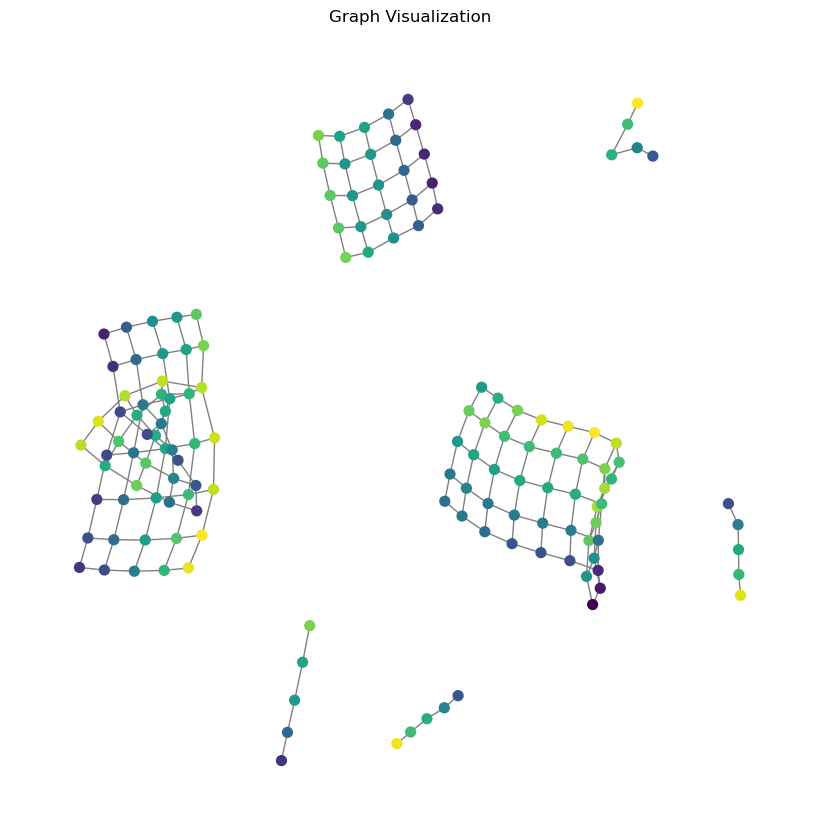

In [166]:
# Set up node features as a color map (optional)
node_colors = graph.x[:, 0].cpu().numpy()  # Example: Use the first feature as color

# Draw the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(nx_graph)  # Spring layout for better visualization
nx.draw(
    nx_graph, pos,
    node_color=node_colors, cmap=plt.cm.viridis,  # Color nodes by features
    with_labels=False, node_size=50, edge_color="gray"
)
plt.title("Graph Visualization")
plt.show()
